In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
import seaborn as sns
%matplotlib inline

import pywt
import scipy
from scipy import signal
from scipy.signal import butter, deconvolve

In [2]:
test_path = os.path.join('data','test.csv')
train_path = os.path.join('data','train.csv')

test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)

In [3]:
train_df.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [4]:
test_df.head()

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


Visualising the training dataset to see if we need to remove any anaomalies

[Text(0, 0.5, 'signal (pA)'),
 Text(0.5, 0, 'time (s)'),
 Text(0.5, 1.0, 'Signal(pA) over time(s)')]

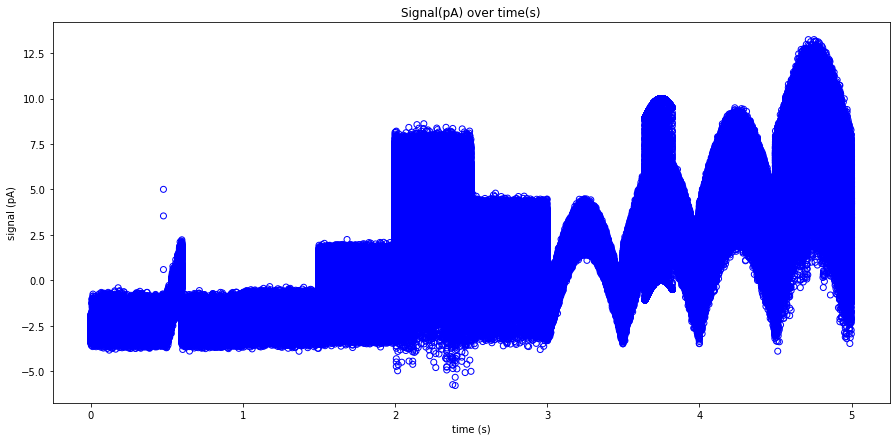

In [5]:
fig0, ax0 = plt.subplots(figsize=(15,7))

time_train = (train_df.time)/100 # this is for readability
signal_train = train_df.signal
open_channels_train = train_df.open_channels

ax0.scatter(time_train, signal_train, color='none', edgecolor='blue', marker='o');
ax0.set(xlabel='time (s)', ylabel='signal (pA)',
        title='Signal(pA) over time(s)')

The first graph clearly shows that between 0 and 1.5 seconds show a signal range of -2.5 to 0 pA.  There could either be anomolies or the initiation of ion channels of up to 5 pA.  The signals start to show a consistant positive signal after 1.5 seconds, however, it shows a range of ~ -5 to 13 pA. After 3 seconds, there are almost 'leapfrongs' in the intensity of signals ranging from ~ -5 to 13 pA as said before.

[Text(0, 0.5, 'signal (pA)'),
 Text(0.5, 0, 'Number of open Channels'),
 Text(0.5, 1.0, 'Signal and Number of Open Channels')]

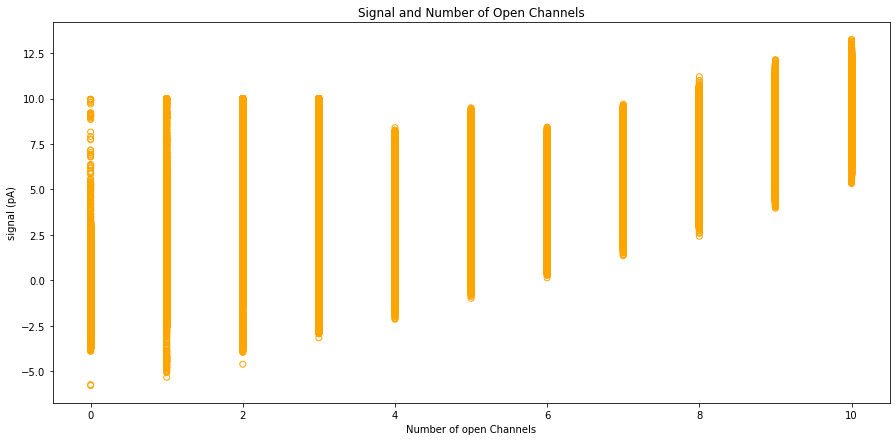

In [6]:
fig1, ax1 = plt.subplots(figsize=(15,7))

ax1.scatter(open_channels_train, signal_train, color='none', edgecolor='orange')
ax1.set(xlabel='Number of open Channels', ylabel='signal (pA)',
        title='Signal and Number of Open Channels')

From judging the graph above, there is a clear and distinct correlation with signal levels and the number orf open channels.  There appears to be a large range of signals when the number of channels is lower, when the number of channels get closer to 10, the range becomes smaller and more defined.

[Text(0, 0.5, 'Number of Open Channels'), Text(0.5, 0, 'Time')]

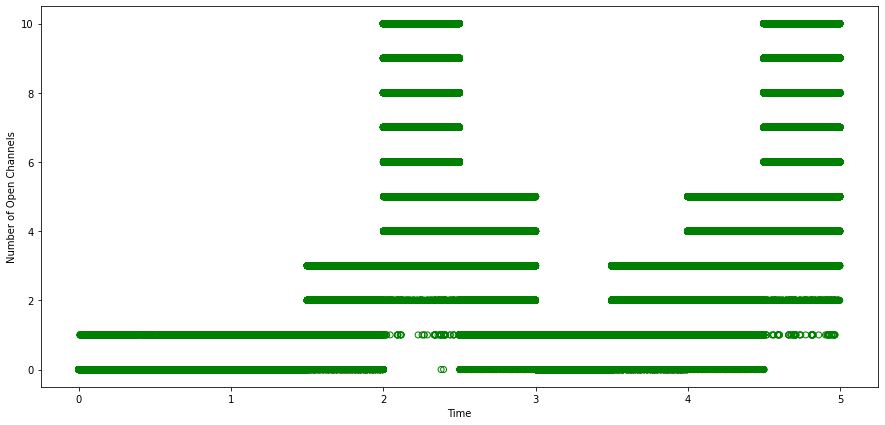

In [7]:
fig2, ax2 = plt.subplots(figsize=(15,7))
ax2.scatter(time_train, open_channels_train, color='none', edgecolor='green')
ax2.set(xlabel='Time', ylabel='Number of Open Channels')

[Text(0.5, 0, 'open channels'),
 Text(0.5, 0, 'signal (pA)'),
 Text(0.5, 0, 'time (s)')]

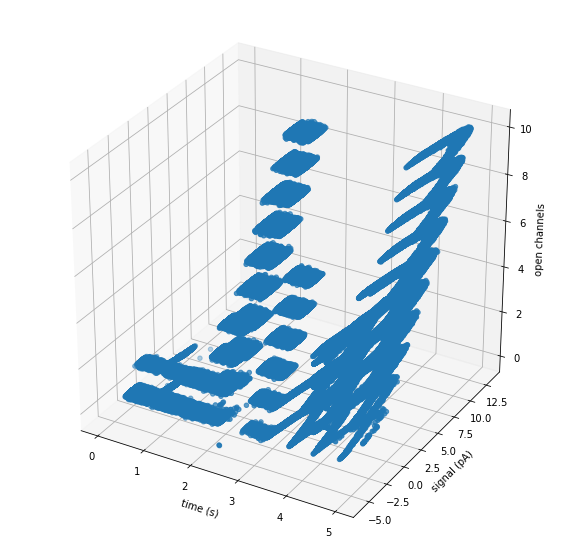

In [8]:
fig3 = plt.figure(figsize=(10,10))
ax3 = plt.axes(projection="3d")

time_train = (train_df.time)/100 # this is for readability
signal_train = train_df.signal
open_channels_train = train_df.open_channels

x = time_train
y = signal_train
z = open_channels_train

ax3.scatter(x, y, z)
ax3.set(xlabel='time (s)', ylabel='signal (pA)', zlabel='open channels')

This does not help

In [9]:
train_df.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


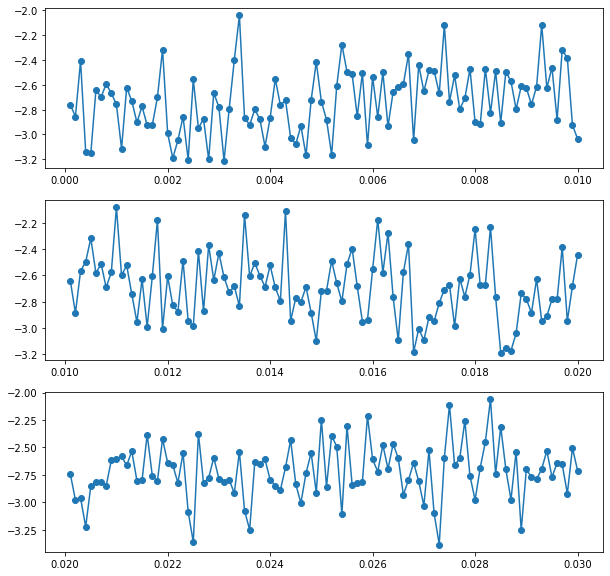

In [10]:
x_1 = train_df.time[0:100]
y_1 = train_df.signal[0:100]

x_2 = train_df.time[100:200]
y_2 = train_df.signal[100:200]

x_3 = train_df.time[200:300]
y_3 = train_df.signal[200:300]

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
(ax1, ax2, ax3) = axs

ax1.plot(x_1, y_1, '-o')
ax2.plot(x_2, y_2, '-o')
ax3.plot(x_3, y_3, '-o')


Having a closer look at the data, there is a lot of noise so we need to remove the noise with wavelet denoising

In [11]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')


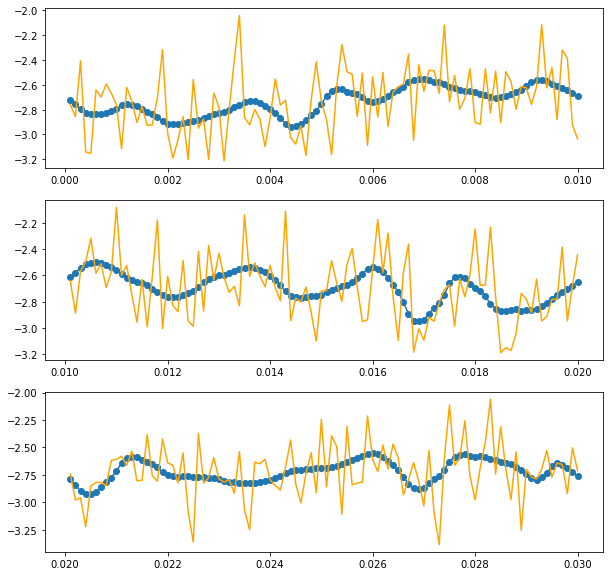

In [12]:
x_1 = train_df.time[0:100]
x_2 = train_df.time[100:200]
x_3 = train_df.time[200:300]

y_1 = train_df.signal[0:100]
y_2 = train_df.signal[100:200]
y_3 = train_df.signal[200:300]

y_1_transformed = denoise_signal(train_df.signal[0:100])

y_2_transformed = denoise_signal(train_df.signal[100:200])

y_3_transformed = denoise_signal(train_df.signal[200:300])

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
(ax1, ax2, ax3) = axs

ax1.plot(x_1, y_1_transformed, '-o')
ax2.plot(x_2, y_2_transformed, '-o')
ax3.plot(x_3, y_3_transformed, '-o')

ax1.plot(x_1, y_1, color='orange')
ax2.plot(x_2, y_2, color='orange')
ax3.plot(x_3, y_3, color='orange')


[Text(0, 0.5, 'signal (pA)'),
 Text(0.5, 0, 'time (s)'),
 Text(0.5, 1.0, 'Signal(pA) over time(s)')]

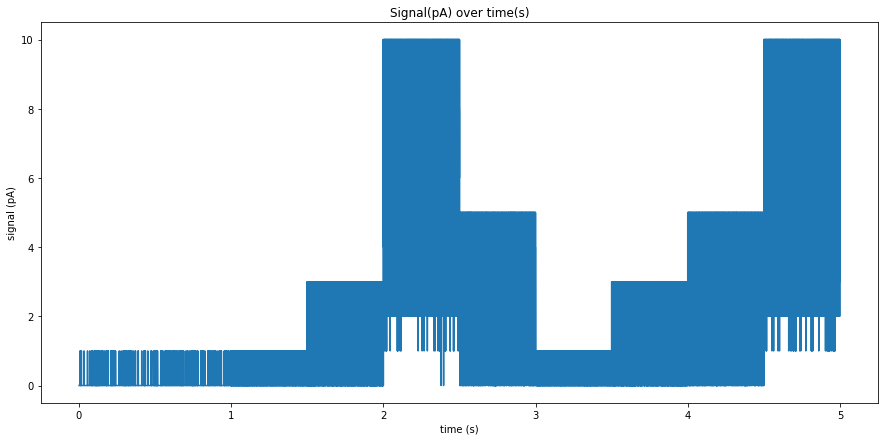

In [13]:
fig0, ax0 = plt.subplots(figsize=(15,7))

time_train = (train_df.time)/100 # this is for readability
signal_train = train_df.signal
signal_train_denoised = denoise_signal(train_df.signal)

open_channels_train = train_df.open_channels

# ax0.plot(time_train, signal_train,'-o');
# ax0.plot(time_train, signal_train_denoised,'-o');
ax0.plot(time_train, open_channels_train)

ax0.set(xlabel='time (s)', ylabel='signal (pA)',
        title='Signal(pA) over time(s)')

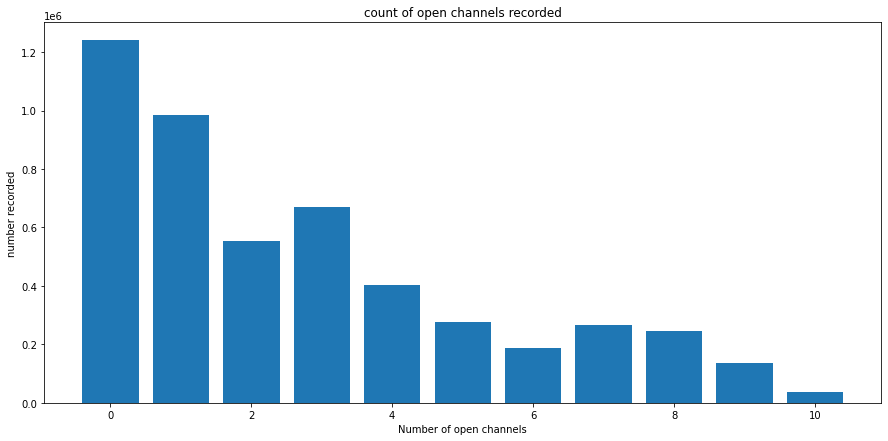

In [14]:
fig2, ax2 = plt.subplots(figsize=(15,7))
ax2.bar(x=list(range(11)), height=open_channels_train.value_counts(sort=False).values)
ax2.set(xlabel='Number of open channels', ylabel='number recorded',
        title='count of open channels recorded');

In [15]:
open_channel_0 = train_df.loc[train_df['open_channels']==0]
open_channel_1 = train_df.loc[train_df['open_channels']==1]
open_channel_2 = train_df.loc[train_df['open_channels']==2]
open_channel_3 = train_df.loc[train_df['open_channels']==3]
open_channel_4 = train_df.loc[train_df['open_channels']==4]
open_channel_5 = train_df.loc[train_df['open_channels']==5]
open_channel_6 = train_df.loc[train_df['open_channels']==6]
open_channel_7 = train_df.loc[train_df['open_channels']==7]
open_channel_8 = train_df.loc[train_df['open_channels']==8]
open_channel_9 = train_df.loc[train_df['open_channels']==9]
open_channel_10 = train_df.loc[train_df['open_channels']==10]

In [16]:
open_channel_avg_signal_list = [np.mean(denoise_signal(globals()[f'open_channel_{i}'].signal)) for i in range(11)]
open_channel_avg_signal_list

[-2.2617531376514575,
 0.04517022326096928,
 1.3180792522856881,
 2.527445059372603,
 3.572784175635032,
 4.1291211994927615,
 3.539647337213295,
 4.761488872608758,
 5.9984444158434425,
 7.2147441241960735,
 8.465608551983939]

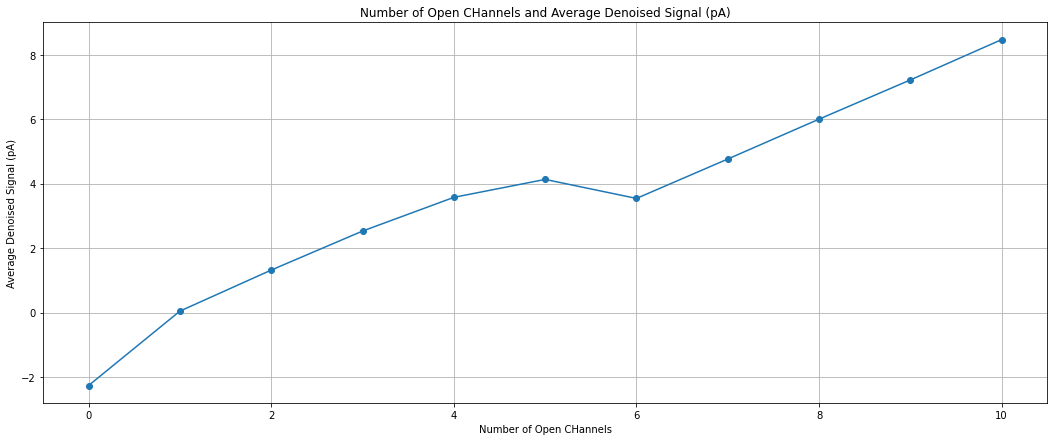

In [17]:
fig0, ax0 = plt.subplots(figsize=(18,7))
ax0.plot(list(range(11)),open_channel_avg_signal_list,'-o')
ax0.grid()
ax0.set(xlabel='Number of Open CHannels', ylabel='Average Denoised Signal (pA)',
        title='Number of Open CHannels and Average Denoised Signal (pA)');

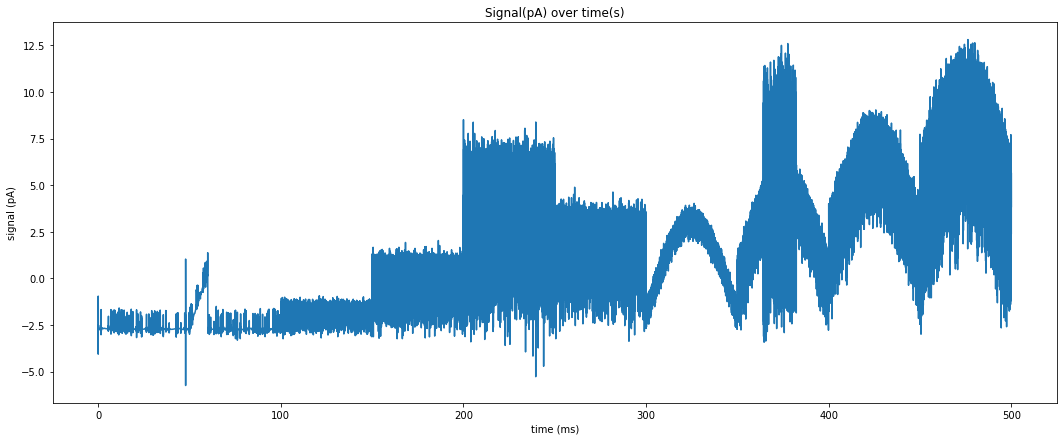

In [18]:
fig0, ax0 = plt.subplots(figsize=(18,7))

time_train = train_df.time # this is for readability
signal_train = train_df.signal
signal_train_denoised = denoise_signal(train_df.signal)

open_channels_train = train_df.open_channels
ax0.plot(time_train, signal_train_denoised);
ax0.set(xlabel='time (ms)', ylabel='signal (pA)',
        title='Signal(pA) over time(s)');

[Text(0.5, 0, 'open channels'),
 Text(0.5, 0, 'signal (pA)'),
 Text(0.5, 0, 'time (s)')]

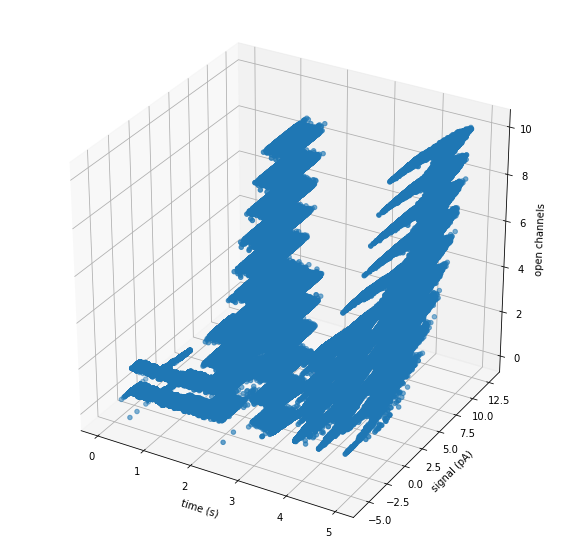

In [19]:
fig3 = plt.figure(figsize=(10,10))
ax3 = plt.axes(projection="3d")

time_train = (train_df.time)/100 # this is for readability
signal_train = train_df.signal
open_channels_train = train_df.open_channels

x = time_train
y = denoise_signal(train_df.signal)
z = open_channels_train

ax3.scatter(x, y, z)
ax3.set(xlabel='time (s)', ylabel='signal (pA)', zlabel='open channels')

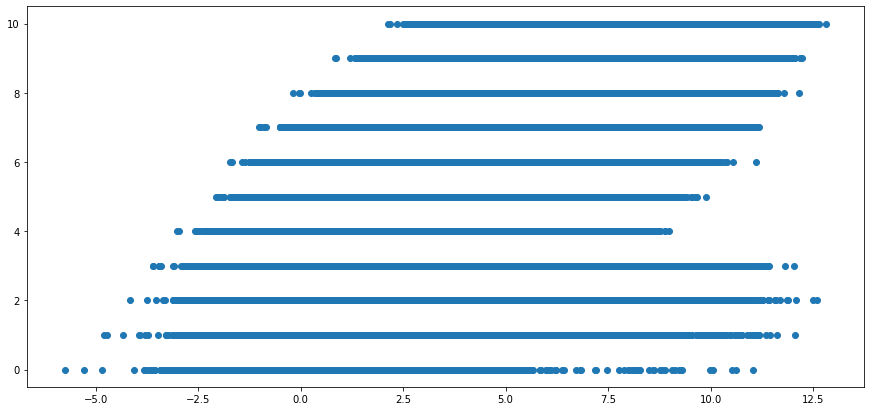

In [20]:
signal_train_denoised = denoise_signal(train_df.signal)
open_channels_train = train_df.open_channels

fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(signal_train_denoised, open_channels_train)

In [21]:
# fig0, ax0 = plt.subplots(figsize=(18,7))

# time_train = (train_df.time)/100 # this is for readability
# signal_train = train_df.signal
# signal_train_denoised = denoise_signal(train_df.signal)

# open_channels_train = train_df.open_channels
# ax0.bar(x=open_channels_train, height=signal_train_denoised);
# ax0.set(xlabel='time (s)', ylabel='signal (pA)',
#         title='Signal(pA) over time(s)');

Going to do some quick sklearn stuff, need to prepare the data for such stuff

In [22]:
time_train = train_df.time
signal_train_denoised = denoise_signal(train_df.signal)
open_channels_train = train_df.open_channels

data = {
    'time': time_train,
    'signal_denoised': signal_train_denoised,
    'open_channels_train': open_channels_train
       }

train_data = pd.DataFrame(data=data)

In [23]:
train_data.tail()

,time,signal_denoised,open_channels_train
4999995,499.9996,3.296552,7
4999996,499.9997,3.586595,7
4999997,499.9998,3.957363,8
4999998,499.9999,4.474106,9
4999999,500.0000,2.416632,9


Linear model - Linear Regression

In [24]:
from sklearn.model_selection import train_test_split

X = train_data[['time','signal_denoised']]
y = train_data.open_channels_train.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression(n_jobs=-1)
model.fit(X_train,y_train)
model.score(X_train,y_train)
predict = model.predict(X_test)

print(f'''
Prediction: \n{predict[:10]}


Actual: \n{y_test[:10]}

train_score: \n{model.score(X_train,y_train)}

test score: \n{model.score(X_test,y_test)}
''')


Prediction: 
[[1.99840699]
 [2.27377874]
 [2.78218764]
 [4.27818396]
 [0.29438019]
 [3.46437104]
 [3.75912775]
 [4.0347391 ]
 [0.50112851]
 [1.90555461]]


Actual: 
[[1]
 [7]
 [2]
 [4]
 [0]
 [4]
 [1]
 [1]
 [0]
 [1]]

train_score: 
0.6330320186379447

test score: 
0.6338297510468474



Deep Learning model testing

In [26]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

C:\Users\Ayman\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Ayman\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Ayman\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Ayman\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import sparse_categorical_crossentropy
X = train_data[['time','signal_denoised']]
y = train_data.open_channels_train.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

C:\Users\Ayman\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [28]:
y_train_categorical

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=2))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=11, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               300       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                1111      
Total params: 11,511
Trainable params: 11,511
Non-trainable params: 0
_________________________________________________________________


In [30]:
print(X_train_scaled)
print('------------------')
print(y_train)

[[0.68412467 0.36439578]
 [0.31853333 0.29845196]
 [0.82494453 0.5418349 ]
 ...
 [0.98529699 0.64294097]
 [0.86091454 0.5529714 ]
 [0.33854854 0.24201497]]
------------------
[[1]
 [2]
 [3]
 ...
 [7]
 [2]
 [1]]


In [31]:
# model.fit(
#     X_train_scaled,
#     y_train_categorical,
#     epochs=1,
#     shuffle=True,
#     verbose=2
# )

In [32]:
# model_loss, model_accuracy = model.evaluate(
#     X_test_scaled, y_test_categorical, verbose=2)
# print(
#     f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

1000000/1000000 - 38s - loss: 2.3956 - acc: 0.0553
Normal Neural Network - Loss: 2.39561207094574, Accuracy: 0.05534299835562706


In [33]:
# encoded_predictions = model.predict_classes(X_test_scaled[:100])
# prediction_labels = label_encoder.inverse_transform(encoded_predictions)

# from pprint import pprint

# pprint(f"Predicted classes: {list([i for i in prediction_labels])}")
# pprint(f"Actual Labels: {[i[0] for i in y_test[:100]]}")

('Predicted classes: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, '
 '5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, '
 '5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, '
 '5, 9, 5, 5, 9, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, '
 '5, 5, 5, 9, 5, 5]')
('Actual Labels: [1, 7, 2, 4, 0, 4, 1, 1, 0, 1, 7, 1, 2, 0, 0, 1, 1, 1, 7, 1, '
 '8, 0, 2, 7, 4, 0, 5, 3, 0, 8, 3, 1, 3, 0, 3, 9, 0, 1, 5, 6, 0, 3, 2, 1, 4, '
 '1, 3, 0, 1, 1, 0, 0, 0, 2, 7, 0, 0, 1, 2, 0, 2, 2, 3, 4, 5, 1, 8, 1, 2, 6, '
 '0, 7, 4, 0, 1, 7, 0, 0, 3, 1, 0, 0, 0, 0, 2, 3, 1, 0, 7, 1, 1, 1, 1, 1, 4, '
 '0, 9, 0, 4, 10]')


In [43]:
def deep_learning_model(X, y, inputs=2, epochs=10, outputs=11):
    import tensorflow as tf
    import datetime
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler, LabelEncoder
    from tensorflow.keras.losses import sparse_categorical_crossentropy
    from tensorflow.keras.utils import to_categorical

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_scaler = MinMaxScaler().fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    label_encoder = LabelEncoder()
    label_encoder.fit(y_train)
    encoded_y_train = label_encoder.transform(y_train)
    encoded_y_test = label_encoder.transform(y_test)

    y_train_categorical = to_categorical(encoded_y_train)
    y_test_categorical = to_categorical(encoded_y_test)
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    
    model = Sequential()
    model.add(Dense(units=100, activation='relu', input_dim=inputs))
    model.add(Dense(units=200, activation='relu'))
    model.add(Dense(units=300, activation='relu'))
    model.add(Dense(units=200, activation='relu'))
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=outputs, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    
    model.fit(
        X_train_scaled,
        y_train_categorical,
        epochs=epochs,
        shuffle=True,
        verbose=2
    )
    
    
    print('\n----------------------------------------------------------------\n')
    
    model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
    print(f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")
    
    encoded_predictions = model.predict_classes(X_test_scaled[:100])
    prediction_labels = label_encoder.inverse_transform(encoded_predictions)

    return print(f'''
    Predicted classes: {list([i for i in prediction_labels])}
    Actual Labels: {[i[0] for i in y_test[:100]]}
    ''')

In [44]:
X = train_data[['time','signal_denoised']]
y = train_data.open_channels_train.values.reshape(-1,1)
q = deep_learning_model(X=X,y=y ,inputs=2,epochs = 50)
q

C:\Users\Ayman\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_19 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_20 (Dense)             (None, 300)               60300     
_________________________________________________________________
dense_21 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_23 (Dense)             (None, 11)                1111      
Total params: 162,211
Trainable params: 162,211
Non-trainable params: 0
________________________________________________